# PFL with Regret Minimization

## Simplified Algorithm 

Step 1: Initialize weights w.

Step 2: Randomly choose a set $i' = i_1, ..., i_B$ from the available clients.

Step 3: Use the local dataset $D_{i'}$ to perform a gradient descent step:
$ \tilde{w}^{(i, i')} = w^{(i)} - \alpha \nabla L_{i'}(w^{(i)}) $

Step 4: Compute rewards $r_{i,i'}$ for $i' = i_1, ..., i_B$ at each task.
$r_{i,i'} = L_{i}(w^{(i)}) - L_{i}(\tilde{w}^{(i, i')})$

Step 5: Use the gradient step for the local dataset i with the largest reward $r_{i,i'}$.

Step 6: If the stopping criterion is not met, continue with step 2.




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
import random
import math

In [2]:
class Client:
    def __init__(self, NUM_SAMPLES, num_features, weights, true_w, std=0.01):
        self.weights = weights

        self.X, self.y = generate_data(NUM_SAMPLES, num_features,
                                       true_w, std)  
        self.GT_w = true_w
        
    def find_w_candidate(self, X, y, lr):
        weights = self.weights.clone()
        weights.requires_grad_()
        weights.grad = None
        prediction = X @ weights
        loss_ = ((prediction - y) ** 2).mean()
        loss_.backward()
        
        grad = weights.grad.clone()
        with torch.no_grad():
            w_candidate = weights - lr * grad
        return w_candidate
    
    def get_local_loss(self, weights):
        prediction = self.X @ weights
        loss_ = ((prediction - self.y) ** 2).mean()
        return loss_
    
    def train_locally(self, L, lr):
        weights = self.weights.clone()
        for l in range(0, L):
            weights.requires_grad_()
            weights.grad = None
            prediction = self.X @ weights
            loss_ = ((prediction - self.y) ** 2).mean()
            loss_.backward()
            grad = weights.grad.clone()
            with torch.no_grad():
                weights = weights - lr * grad
        self.weights = weights.detach()
        return weights.detach()
    
    def eval(self, weights):
        with torch.no_grad():
            return ((self.GT_w - weights).norm(p=2)).item()


In [3]:
def generate_data(NUM_SAMPLES, num_features, true_w, std):
    """Generate synthetic data for a user."""
    X = torch.randn(NUM_SAMPLES, num_features, dtype=torch.float64) 
    y = X @ true_w  + std * torch.randn(NUM_SAMPLES, 1)
    return X, y


## Initialization

In [4]:
NUM_SAMPLES = 10
lr = 0.01
GT_weight_list = []
std = math.sqrt(0.001)
NUM_CLUSTERS = 2
NUM_CLIENTS = 100
SUBSET_SIZE = 20
NUM_ROUNDS = 1500

### Getting Clients List

In [5]:
def get_clients_list(num_features):
    one_hotted_GT = torch.from_numpy(np.eye(NUM_CLUSTERS)[np.random.choice(NUM_CLUSTERS,
                                                                           NUM_CLIENTS)].T)  # creates a matrix and indicates which client belongs to which cluster it has k rows and n coloumns
    core_GT_weights = torch.from_numpy(np.random.uniform(low=-5, high=5, size=(num_features, NUM_CLUSTERS)))  # (d, k)
    w_init_mat = torch.randn(num_features, NUM_CLIENTS, requires_grad=False, dtype=torch.float64)

    clients_GT_weights = core_GT_weights @ one_hotted_GT  # (d, n) = (d, k) @ (k, n)
    clients_list = []


    for client_iter in range(NUM_CLIENTS):
        GT_w = clients_GT_weights[:, client_iter].reshape(-1, 1)
        w = w_init_mat[:, client_iter].reshape(-1, 1).clone()
        clients_list.append(Client(NUM_SAMPLES, num_features, w, GT_w, std))
    return clients_list

## Finding  $\tilde{w}$ For Each Task

This section correspond to calculation of reward using `get_w_candidates` and `get_w_with_best_reward` functions. `get_w_candidates` computes $\tilde{w}^{(i, i')}$ for each task in the subset $i' \in \{i_1, ... i_B\}$, and `get_w_with_best_reward` calculates the rewards based on the difference in local loss when using these candidate weights and returns the $ \tilde{w}^{(i, i')}$ with the biggest reward.

In [6]:
def get_w_candidates(clients_list, curr_client_id, client_ids, lr):
    curr_client = clients_list[curr_client_id]
    candidates = torch.zeros((num_features, SUBSET_SIZE), dtype=torch.float64)
    for iter_client in range(SUBSET_SIZE):
        id_ = client_ids[iter_client]
        client = clients_list[id_]
        w_iter = client.find_w_candidate(client.X, client.y, lr)
        candidates[:, iter_client] = w_iter.squeeze()
    return candidates

In [7]:
def get_w_with_best_reward(candidates, client):
    current_loss = client.get_local_loss(client.weights)
    rewards = torch.empty((SUBSET_SIZE), dtype=torch.float64)
    for iter_client in range(SUBSET_SIZE):
        rewards[iter_client] = current_loss - client.get_local_loss(candidates[:, iter_client].reshape(num_features, 1))
    idx_max_reward = torch.argmax(rewards)
    return candidates[:, idx_max_reward]

#### Finding Subset of Tasks (Step 2)

In [8]:
def get_random_indices_without_i():
    indices = np.arange(0, NUM_CLIENTS)
    total_client_ids = np.empty((SUBSET_SIZE, NUM_CLIENTS), dtype=int)

    for iter_client in range(NUM_CLIENTS):
        available_indices = np.delete(indices, iter_client)
        random_indices = np.random.choice(available_indices, size=SUBSET_SIZE, replace=False)
        total_client_ids[:, iter_client] = random_indices
    return total_client_ids


## Implementing Algorithm

In [9]:
def algorithm(clients_list, num_features, num_rounds, lr):
    total_loss = []
    for round_ in range(num_rounds):
        total_subsets = get_random_indices_without_i()
        w_mat = torch.empty((num_features, NUM_CLIENTS), dtype=torch.float64) 
        for iter_client in range(NUM_CLIENTS):
            curr_client_candidates = get_w_candidates(clients_list, iter_client, total_subsets[:, iter_client], lr)
            w_mat[:, iter_client] = get_w_with_best_reward(curr_client_candidates, clients_list[iter_client])
        loss = []
        
        for iter_client in range(NUM_CLIENTS):
            loss.append(clients_list[iter_client].eval(clients_list[iter_client].weights))
            clients_list[iter_client].weights = w_mat[:, iter_client].clone().reshape(-1, 1)
        total_loss.append(sum(loss)/len(loss))   
    return total_loss

## A Baseline: Training Independently

In [10]:
def train_seperately(clients_list, num_features, num_rounds, lr):
    list_loss_tot_ind = []
    for round_ in range(0, num_rounds):
        list_loss_ind = []
        for client_iter in range(0, NUM_CLIENTS):
            list_loss_ind.append(clients_list[client_iter].eval(clients_list[client_iter].weights.detach()))
            clients_list[client_iter].train_locally(1,lr)
        list_loss_tot_ind.append(sum(list_loss_ind) / len(list_loss_ind))
    return list_loss_tot_ind

## All Pieces Together:

In [11]:
d_over_m = [0.2, 2, 6, 10, 15, 20]


In [12]:
loss_dm_algo=[]
loss_dm_ind=[]

for i in range(len(d_over_m)):   
    num_features = int(NUM_SAMPLES * d_over_m[i])
    clients_ls = get_clients_list(num_features)

    clients_ls_algo = copy.deepcopy(clients_ls)
    loss_dm_algo.append(algorithm(clients_ls_algo, num_features, NUM_ROUNDS, lr))
    
    clients_ls_ind = copy.deepcopy(clients_ls)
    loss_dm_ind.append(train_seperately(clients_ls_ind, num_features, NUM_ROUNDS, lr))
    


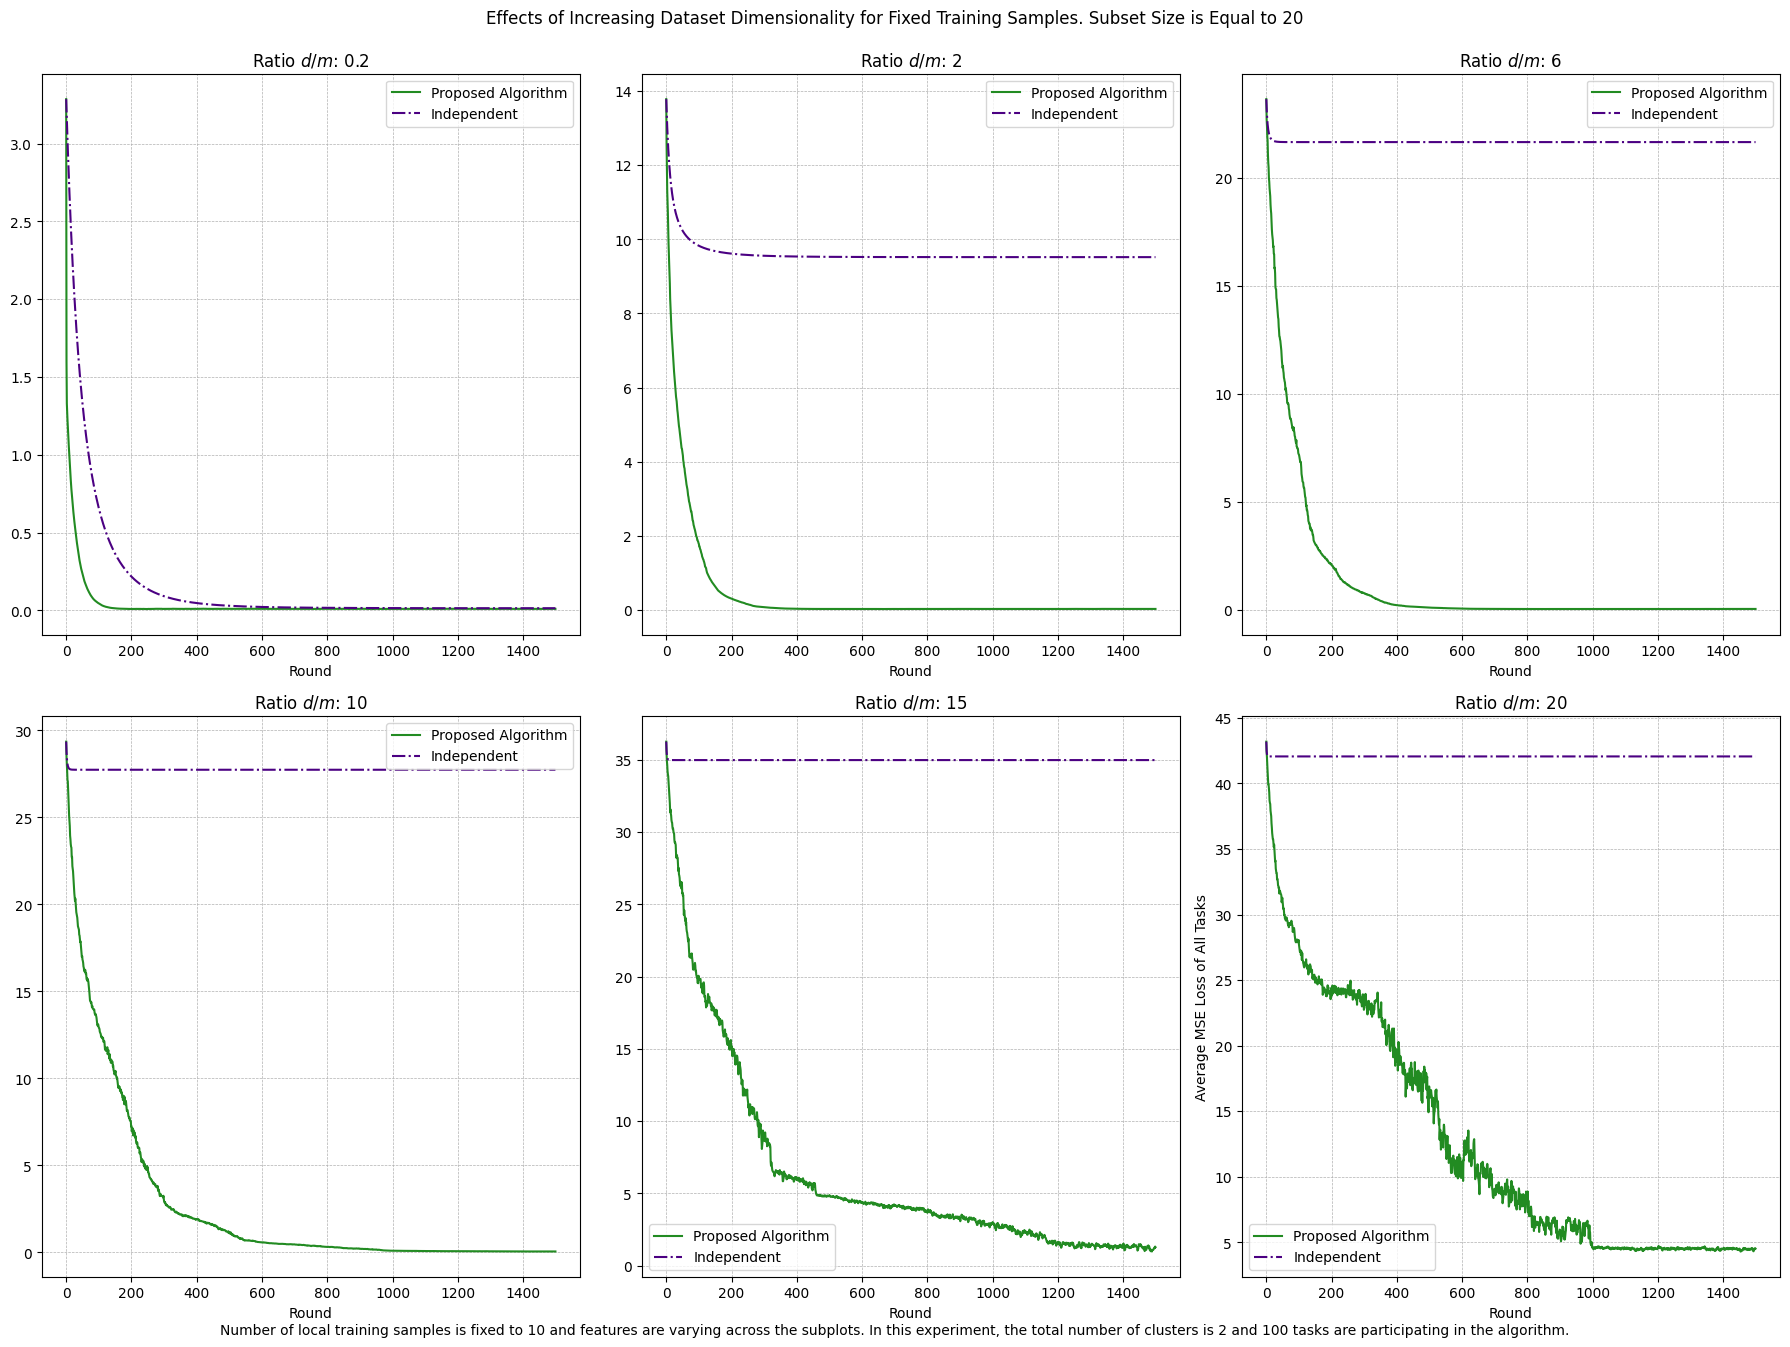

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 13))  # Increase figsize
x = np.arange(NUM_ROUNDS)
for idx, ax in enumerate(axes.ravel()):
    ax.plot(x, loss_dm_algo[idx], label="Proposed Algorithm", linestyle='-',  color='forestgreen')
    ax.plot(x, loss_dm_ind[idx], label=f'Independent', linestyle='-.', color='indigo')    
    ax.set_title(f"Ratio $d/m$: {d_over_m[idx]}")
    ax.set_xlabel('Round') 
    plt.ylabel("Average MSE Loss of All Tasks")
    ax.legend()
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

fig.text(0.5, 0.001, f"Number of local training samples is fixed to {NUM_SAMPLES} and features are varying across the subplots. In this experiment, the total number of clusters is {NUM_CLUSTERS} and {NUM_CLIENTS} tasks are participating in the algorithm.",
         horizontalalignment="center")
fig.tight_layout()
plt.suptitle(f"Effects of Increasing Dataset Dimensionality for Fixed Training Samples. Subset Size is Equal to {SUBSET_SIZE}", y=1.02)
plt.show()